In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
%tensorflow_version 2.x


from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt
from itertools import permutations
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cp gdrive/My\ Drive/lfw-deepfunneled.zip .

In [0]:
%%capture
!unzip lfw-deepfunneled.zip

In [5]:
!pwd

/content


In [0]:
dataset_path = os.path.join('/content', 'lfw-deepfunneled')

In [0]:
label_dict = {}

celeb_count = 0
for celebrity in os.listdir(dataset_path):
  celeb_pic_path = os.path.join(dataset_path, celebrity)
  label_dict[celeb_count] = {'celeb_name': celeb_pic_path,
                  'celeb_pics': os.listdir(celeb_pic_path)}
  celeb_count += 1

In [8]:
label_dict[0]

{'celeb_name': '/content/lfw-deepfunneled/Andy_Roddick',
 'celeb_pics': ['Andy_Roddick_0002.jpg',
  'Andy_Roddick_0009.jpg',
  'Andy_Roddick_0006.jpg',
  'Andy_Roddick_0004.jpg',
  'Andy_Roddick_0003.jpg',
  'Andy_Roddick_0008.jpg',
  'Andy_Roddick_0005.jpg',
  'Andy_Roddick_0010.jpg',
  'Andy_Roddick_0007.jpg',
  'Andy_Roddick_0001.jpg']}

In [9]:
print("Total number of celebrities: ", len(label_dict))

Total number of celebrities:  143


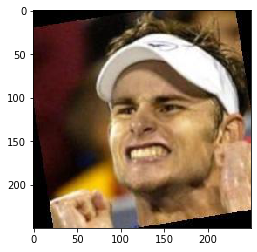

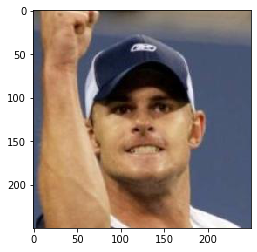

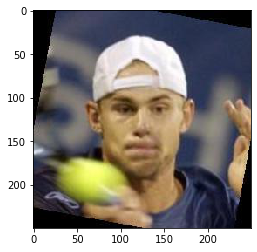

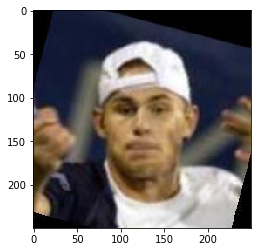

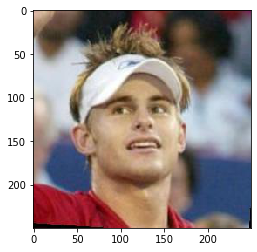

In [10]:
from PIL import Image
import numpy as np

image_list = label_dict[0]['celeb_pics']
celeb_path = label_dict[0]['celeb_name']

for image in image_list[:5]:
  pil_im = Image.open(os.path.join(celeb_path, image)) #Take jpg + png
  im_array = np.asarray(pil_im)
  plt.imshow(im_array)
  plt.show()

In [11]:
im_array.shape

(250, 250, 3)

In [0]:
def get_triplets(n):
  labels = []
  anchor = []
  pos =[]
  neg =[]

  for i in range(n):
    smpl = random.sample(range(0,5),2)
    anchor_class  = smpl[0]
    neg_class = smpl[1]

    a = os.path.join(label_dict[anchor_class]['celeb_name'], np.random.choice(label_dict[anchor_class]['celeb_pics'],1)[0])
    p = os.path.join(label_dict[anchor_class]['celeb_name'], np.random.choice(label_dict[anchor_class]['celeb_pics'],1)[0])
    n = os.path.join(label_dict[neg_class]['celeb_name'], np.random.choice(label_dict[neg_class]['celeb_pics'],1)[0])

    anchor.append(a)
    pos.append(p)
    neg.append(n)
    labels.append(anchor_class)

  return anchor, pos, neg, labels

In [0]:
# defining triplet loss
def triplet_loss(y_true, y_pred, alpha = 0.4):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [0]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(Conv2D(32,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(32,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(100,name='embeddings'))
    # model.add(Dense(600))
    
    return model

In [0]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [16]:
IMAGE_HEIGHT = 250
IMAGE_WIDTH = 250
NUM_CHANNEL = 3
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL,)

anchor_input = Input(IMG_SIZE, name='anchor_input')
positive_input = Input(IMG_SIZE, name='positive_input')
negative_input = Input(IMG_SIZE, name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network(IMG_SIZE)


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 100)          12731268    anchor_input[0][0]               
                                                                 positive_input[0][0]         

In [0]:
n = 1500

anchor, pos, neg, labels = get_triplets(n)

Anchor = np.zeros((n,IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL))
Positive = np.zeros((n,IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL))
Negative = np.zeros((n,IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL))


In [0]:
for i in range(n):
  Positive[i,:,:,:] = plt.imread(pos[i])

for i in range(n):
  Anchor[i,:,:,:] = plt.imread(anchor[i])

for i in range(n):
  Negative[i,:,:,:] = plt.imread(neg[i])

In [19]:
TEST_SIZE = 0.2
TEST_SAMPLES = int(TEST_SIZE*n)

print(TEST_SAMPLES)

anchor_test, anchor_train = Anchor[:TEST_SAMPLES], Anchor[TEST_SAMPLES:]
positive_test, positive_train = Positive[:TEST_SAMPLES], Positive[TEST_SAMPLES:]
negative_test, negative_train = Negative[:TEST_SAMPLES], Negative[TEST_SAMPLES:]
label_test, label_train = labels[:TEST_SAMPLES], labels[TEST_SAMPLES:]

300


In [20]:
len(label_train)

1200

In [21]:
#Y_dummy = np.empty((Anchor.shape[0],300))
model.fit(x=[anchor_train,positive_train,negative_train],
          y=np.array(label_train),
          validation_data=([anchor_test, positive_test, negative_test], np.array(label_test)),
          batch_size=64,
          epochs=10)

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 [==============================] - 13s 11ms/sample - loss: 18364.6386 - val_loss: 357.5163
Epoch 2/10
1200/1200 [==============================] - 6s 5ms/sample - loss: 105.5045 - val_loss: 24.0798
Epoch 3/10
1200/1200 [==============================] - 6s 5ms/sample - loss: 6.1491 - val_loss: 19.2416
Epoch 4/10
1200/1200 [==============================] - 6s 5ms/sample - loss: 0.0000e+00 - val_loss: 20.0367
Epoch 5/10
1200/1200 [==============================] - 6s 5ms/sample - loss: 0.0000e+00 - val_loss: 20.1806
Epoch 6/10
1200/1200 [==============================] - 6s 5ms/sample - loss: 0.0000e+00 - val_loss: 20.1977
Epoch 7/10
1200/1200 [==============================] - 6s 5ms/sample - loss: 0.0000e+00 - val_loss: 20.2003
Epoch 8/10
1200/1200 [==============================] - 6s 5ms/sample - loss: 0.0000e+00 - val_loss: 20.2002
Epoch 9/10
1200/1200 [==============================] - 6s 5ms/sample - loss: 0.0000

In [0]:
model.save_weights('triplet_model_celeb.hdf5')

In [0]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)

trained_model.load_weights('triplet_model_celeb.hdf5')

In [0]:
a1 = trained_model.predict(anchor_test[0].reshape(-1,IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL))
p1 = trained_model.predict(positive_test[0].reshape(-1,IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL))
n1 = trained_model.predict(negative_test[0].reshape(-1,IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL))

In [25]:
np.sum((a1 - p1)**2)

38215.508

In [26]:
np.sum((p1 - n1)**2)

87222.664

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


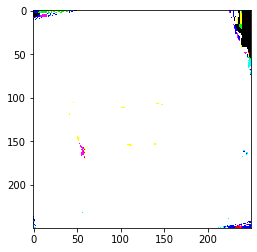

In [27]:
plt.imshow(anchor_test[0])
plt.show()

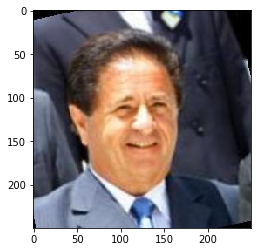

In [28]:
pil_im = Image.open(anchor[0]) #Take jpg + png
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()